# Data Analysis by Xu Si

The dataset is obtained from UKDS https://discover.ukdataservice.ac.uk/catalogue/?sn=7841&type=Data%20catalogue#documentation

The Welsh Health Survey (WHS) collects information about the health of people living in Wales, which is based on a representative sample of adults aged 16 and over living in private households in Wales. In addition, up to two children aged 0 to 15 were randomly selected from each household.

My objective is to mainly look at the adults group and see what are the key factors for epilepsy disease.

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
%matplotlib inline

In [140]:
data = pd.read_csv("Welsh Health Status/tab/whs_2014_adult_archive.tab", delimiter='\t')
data.head()

,archhsn,archpsn,tenure3,hhdtypb,nssec8,nssec5,nssec3,hhchild,region,whsyear,...,exvigno,exerv,exercise,exergrp,exergrp5,exerstr,exer0,noex,wt_hhold,wt_adult
0,1001011,100101101,1,7,6,5,3,2,2,11,...,0,4,1,2,5,3,0,1,1.342344,1.132830
1,1001021,100102101,3,2,2,1,1,2,2,11,...,0,3,0,1,4,3,0,1,1.759103,2.053860
2,1001021,100102102,3,2,2,1,1,2,2,11,...,0,7,1,2,5,3,0,1,1.759103,2.565752
3,1001041,100104101,3,3,-9,-9,-9,1,2,11,...,1,0,0,1,4,2,0,1,1.465895,1.783198
4,1001061,100106101,3,1,6,5,3,2,2,11,...,1,0,0,0,0,0,1,0,1.314582,1.349142


# Data cleaning

In [141]:
data.head()

,archhsn,archpsn,tenure3,hhdtypb,nssec8,nssec5,nssec3,hhchild,region,whsyear,...,exvigno,exerv,exercise,exergrp,exergrp5,exerstr,exer0,noex,wt_hhold,wt_adult
0,1001011,100101101,1,7,6,5,3,2,2,11,...,0,4,1,2,5,3,0,1,1.342344,1.132830
1,1001021,100102101,3,2,2,1,1,2,2,11,...,0,3,0,1,4,3,0,1,1.759103,2.053860
2,1001021,100102102,3,2,2,1,1,2,2,11,...,0,7,1,2,5,3,0,1,1.759103,2.565752
3,1001041,100104101,3,3,-9,-9,-9,1,2,11,...,1,0,0,1,4,2,0,1,1.465895,1.783198
4,1001061,100106101,3,1,6,5,3,2,2,11,...,1,0,0,0,0,0,1,0,1.314582,1.349142


Let us have a look at a scale predictor and a nominal predictor

In [120]:
print "Number of Predictors: ", data.shape[1]
print "Adult Population Size: ", data.shape[0]

Number of Predictors:  468
Adult Population Size:  14170


In [121]:
#a scale predictor "weight"
data[["wtkg"]].head()

,wtkg
0,80.29
1,73.94
2,88.91
3,102.97
4,50.80


In [122]:
# a nominal predictor 
data[["hhchild"]].head()

,hhchild
0,2
1,2
2,2
3,1
4,2


Now we need to filter out the observations that is sure to have/not have epilepsy.

In [179]:
#filter the data, 
epi = data[data["epibi"] >= 0]
print epi.shape

(13393, 468)


Find and get dummies for the nominal predictors.

In [143]:
#get dummies for the nominal predictors
f = open("Welsh Health Status/mrdoc/allissue/whs_2014_adult_archive_ukda_data_dictionary.rtf", 'r')
info = f.read()  

#set target string 
target_string = 'the SPSS measurement level is'
# locate target string in the whole file
target_loc = [m.start() for m in re.finditer(target_string, info)]

In [145]:
# identify categorical variables by target strings in explain file
nominal_col = []

for index, loc in enumerate(target_loc):
    # get feature character
    char = info[loc+len(target_string)+10]
    if epi.columns[index] == "epi" or epi.columns[index] == "epibi":
        continue
    elif char == "N":
        nominal_col.append(index)
        
print "Number of categorical predicors: ", len(nominal_col)
print "Number of numeric predictors:", len(epi.columns.values) - len(nominal_col) - 2
print "Number of all predictors: ", len(epi.columns.values) -2

Number of categorical predicors:  354
Number of numeric predictors: 112
Number of all predictors:  466


In [238]:
col_name + "_" + str(names[i])

'tenure3_2'

In [240]:
#get dummies
#Create a new data frame 
x = pd.DataFrame({}) 
predictor_list = []

# Iterate over all attributes
for i in range(2,epi.shape[1]):
    #get the name of the column
    col_name = epi.columns.values[i]
    
    if i in nominal_col:
        encoding = pd.get_dummies(epi[col_name])
        
        temp = []
        names = encoding.columns.values
        for i in range(len(names)):
            temp.append(col_name + "_" + str(names[i]))
        encoding.columns = temp
        
        # append expanded attribute to data frame
        x = pd.concat([x, encoding], axis=1)
        # update predictor_list
        #predictor_list.extend([(col_name + "_" + str(value)) for value in encoding.columns.values] )
    else:
        x = pd.concat([x, epi[col_name]], axis=1)
        predictor_list.append(col_name)

print x.shape
print len(predictor_list)
x.head(n=3)

(13393, 1788)
112


,tenure3_-9,tenure3_1,tenure3_2,tenure3_3,hhdtypb_1,hhdtypb_2,hhdtypb_3,hhdtypb_4,hhdtypb_5,hhdtypb_6,...,exerstr_2,exerstr_3,exer0_-9,exer0_0,exer0_1,noex_-9,noex_0,noex_1,wt_hhold,wt_adult
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.342344,1.132830
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.759103,2.053860
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.759103,2.565752


In [241]:
predictor_list.remove("epi")
predictor_list.remove("epibi")
y = x["epibi"].values
x = x.drop(["epi","epibi"], axis=1)
print x.shape

(13393, 1786)


# Fit model select feature

In [134]:
regularization = 10.**np.arange(-10, 5)
logistic = LogRegCV(cv=5, 
                    penalty='l2', 
                    Cs=regularization, 
                    solver='liblinear', 
                    n_jobs=4)
logistic.fit(x, y)

LogisticRegressionCV(Cs=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=4, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [242]:
coef = pd.DataFrame({"predictor":x.columns.values,"coeffecients":logistic.coef_[0,:]})

In [244]:
coef_importance = coef.sort_values("coeffecients")

In [323]:
#top 30 and bottome 30 features
top = coef_importance.iloc[-30:,:]
bottom = coef_importance.iloc[:30,:]
print top

      coeffecients    predictor
68        0.221849     health_2
1028      0.223078    emoless_5
352       0.224381    outpriv_1
1063      0.227223       nerv_3
49        0.233557    intmon_11
1532      0.238120    nodrink_1
1044      0.238304    bodpain_3
585       0.240672      arth_-9
588       0.240672    arthbi_-9
991       0.244981       bath_2
117       0.251549       nvq2_1
18        0.253573     nssec8_7
184       0.258570    wbworth_7
234       0.260961      wbanx_3
1131      0.263076   worshlth_5
478       0.308930   prescmed_1
482       0.308930   prescmbi_1
570       0.314790       anx_-9
573       0.314790     anxbi_-9
576       0.345173   mentoth_-9
579       0.345173  mentotbi_-9
91        0.366455       work_8
600       0.395131   vveinbi_-9
597       0.395131     vvein_-9
594       0.398235    backbi_-9
591       0.398235      back_-9
739       0.568441   mrg_ills_2
742       0.625147    chronic_1
1304      0.825770    lltich1_4
1191      0.977240    llticd1_6


In [206]:
#Print results
print 'Accuracy on overall data:', logistic.score(x, y)
print 'Accuracy on class 0 :', logistic.score(x[y == 0], y[y == 0])
print 'Accuracy on class 1 :', logistic.score(x[y == 1], y[y == 1])

Accuracy on overall data: 0.99342940342
Accuracy on class 0 : 1.0
Accuracy on class 1 : 0.357664233577


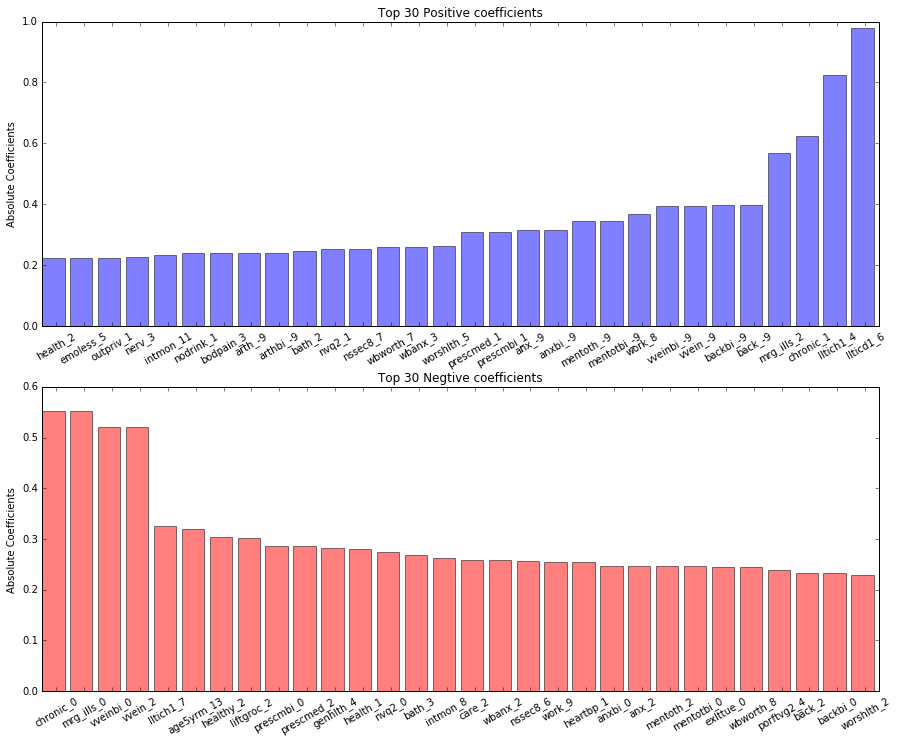

In [327]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

n = 30
#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

#Bar plot of the frequencies of the top words
ax[0].bar(indices, top["coeffecients"], color='blue', alpha=0.5)

ax[0].set_ylabel('Absolute Coefficients')
ax[0].set_title('Top ' + str(n) + " Positive coefficients")

#Label the bars with the top words
ax[0].set_xticks(indices + width)
ax[0].set_xticklabels(top["predictor"])

#Turn the labels sideways so they don't overlap
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)


#Bar plot of the frequencies of the top words
ax[1].bar(indices, np.abs(bottom["coeffecients"]), color='red', alpha=0.5)

ax[1].set_ylabel('Absolute Coefficients')
ax[1].set_title('Top ' + str(n) + " Negtive coefficients")

#Label the bars with the top words
ax[1].set_xticks(indices + width)
ax[1].set_xticklabels(bottom["predictor"])

#Turn the labels sideways so they don't overlap
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()
fig.savefig("Impor_featr.jpg")

Some of the Top 30 positive coefficients:
1.Limiting long term illness main cause: Epilepsy/fits/convulsions
2.Limiting long term illness main cause: Mental illness/anxiety/depression/nerves (nes)
3.(D) Any chronic illness currently treated: Yes
4.(D) (Merged 2+) Number of currently treated illnesses: 2+ currently treated illnesses
5. Back pain - currently treated: No answer/refused
6. Work status: Permanently unable to work because of long-term sickness/disability 
7. (D) Currently treated for other mental illness - binary: No answer/refused
8. (D) Currently treated for anxiety - binary: No
9. Regular prescribed medication: Yes
10. SF Expect my health to get worse: Definitely false
11. Anxious yesterday: level 3/10
12. Worthwhile: level 7/10
13. (D) NS-SEC 8 classes: Routine occupations
14. NVQ Level 2, Intermediate GNVQ, etc.: Yes
15. SF Health limits bathing or dressing yourself: Yes, limited a little
16. SF Bodily pain in past 4 weeks: Mild
17. Always non-drinker or stopped: Always a non-drinker 
18. SF Been very nervous in past 4 weeks: Some of the time
19. Outpatient paid for privately: Yes

We can see from the visulization above what does life of epilepsy patients look like.

Among the top close-related features, we can see that epilepsy patients (more likely):
- Are Permanently unable to work because of long-term sickness/disability
- Have Regular prescribed medication
- Definitely not expect health to get worse
- Has Anxious Level 3/10 Yesterday
- Have intermediate occupations
- Have Routine occupations
- Have a Little Health limits bathing or dressing themselves
- Have mild body pain in past 4 weeks
- Are Always a non-drinker
- Some of the time been very nervous in past 4 weeks
- Due to physical health cut down time on work or activities in past 4 weeks some of the time
- Some of the time feeling happy
- Have a Little Health limits walking more than a mile 

Life for epilepsy patients are not as easy and pleasant as normal people. They sometimes feel anxious, have to give up drinking and suffer a little limits of living a better life. Looking at the data, we can imagine the quality of life of epilepsy patients because seizures can happen anytime. This unpredictable disease causes fear and anxiety. 

People who have first seizures are potential candidates for having epilepsy, and can be as suffering as epilepsy patients in terms of anxiey and choosing occupations. Thus, it is of great need to predict epilepsy as accurate as possible.

In [250]:
patients = x[y == 1]
n_patients = patients.shape[0]
print n_patients

137


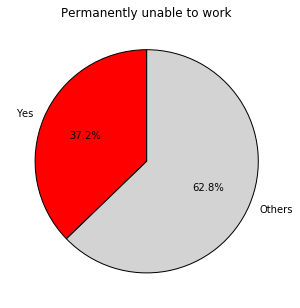

In [315]:
plt.figure(figsize=(5, 5))

plt.pie([sum(work_8), n_patients-sum(work_8)], 
        labels=['Yes' , 'Others'], 
        colors=['red', 'lightgrey'],
        autopct='%1.1f%%', shadow=False, startangle=90)
plt.title("Permanently unable to work")
plt.savefig("Work.png")

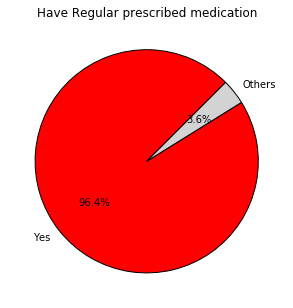

In [329]:
plt.figure(figsize=(5, 5))

plt.pie([sum(prescmbi_1), n_patients-sum(prescmbi_1)], 
        labels=['Yes' , 'Others'], 
        colors=['red', 'lightgrey'],
        autopct='%1.1f%%', shadow=False, startangle=45)
plt.title("Have Regular prescribed medication")
plt.savefig("Medication.png")

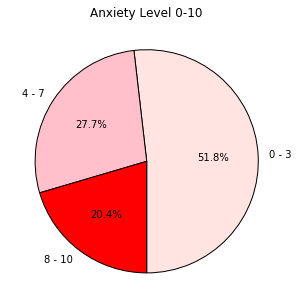

In [334]:
plt.figure(figsize=(5, 5))
plt.pie(count, 
        labels=level, colors=['mistyrose', 'pink','red'],
        autopct='%1.1f%%', shadow=False, startangle=-90)
plt.title("Anxiety Level 0-10")
plt.savefig("Anx.png")

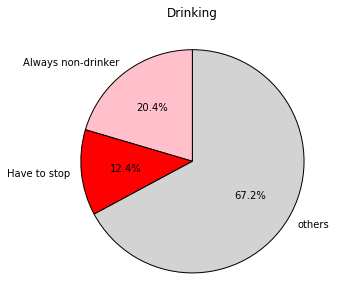

In [335]:
plt.figure(figsize=(5, 5))

plt.pie([sum(nodrink_1),sum(nodrink_2),n_patients -sum(nodrink_1)-sum(nodrink_2) ], 
        labels=['Always non-drinker' , 'Have to stop', "others"], 
        colors=['pink',"red","lightgrey"],
        autopct='%1.1f%%', shadow=False, startangle=90)
plt.title("Drinking")
plt.savefig("Drink.png")

In [331]:
nodrink_2 = patients["nodrink_2"].values
print "epilepsy patients no drink", sum(nodrink_2)
nodrink_1 = patients["nodrink_1"].values
print "epilepsy patients no drink", sum(nodrink_1)

epilepsy patients no drink 17.0
epilepsy patients no drink 28.0


In [274]:
work_8 = patients["work_8"].values
print "epilepsy patients who are Permanently unable to work because of long-term sickness/disability: ",sum(work_8)

epilepsy patients who are Permanently unable to work because of long-term sickness/disability:  51.0


In [257]:
prescmbi_1 = patients["prescmbi_1"].values
print "epilepsy patients who Have Regular prescribed medication", sum(prescmbi_1)

epilepsy patients who Have Regular prescribed medication 132.0


In [336]:
wbanx_0 = patients["wbanx_0"].values
print "epilepsy patients anxiouty level", sum(wbanx_0)
index = []
num = []
for i in range(0,11):
    anx = patients["wbanx_"+str(i)].values
    index.append(str(i))
    num.append(sum(anx))
level = ["0 - 3","4 - 7","8 - 10"]
count = [sum(num[:4]),sum(num[4:8]),n_patients -sum(num[:4])- sum(num[4:8])]
count

epilepsy patients anxiouty level 40.0


[71.0, 38.0, 28.0]

In [259]:
wbanx_10 = patients["wbanx_10"].values
print "epilepsy patients anxiouty level", sum(wbanx_10)

epilepsy patients anxiouty level 4.0


In [262]:
bath_1 = patients["bath_1"].values
print "epilepsy patients anxiouty level", sum(bath_1)

epilepsy patients anxiouty level 28.0


In [266]:
nodrink_2 = patients["nodrink_2"].values
print "epilepsy patients no drink", sum(nodrink_2)

epilepsy patients no drink 17.0


In [270]:
nerv_2 = patients["nerv_2"].values
print "epilepsy patients no drink", sum(nerv_2)

epilepsy patients no drink 19.0
